# **Ajustando o Limite de Decisão (threshold) para Previsão de Classe**



Existem muitas técnicas que podem ser usadas para resolver um problema de classificação desequilibrada, como a reamostragem do conjunto de dados de treinamento e o desenvolvimento de versões personalizadas de algoritmos de aprendizado de máquina. No entanto, talvez a abordagem mais simples para lidar com um grave desequilíbrio de classes seja alterar o limiar de decisão. 


Os modelos de classificação não retornam 0 ou 1, mas sim um valor probabilístico. 
* O **predict_proba** é o método que retorna as estimativas de probabilidade condicionais para cada classe
* O **predict** é o método que faz o ajuste das probabailidades usando o limite de decisão (ou threshold) e assim retorna 0 ou 1. 
* O **threshold** padrão é 0.5, ou seja, se um valor está acima de 0.5 pertence a classe 1, senão a classe 0.


Embora essas regras codificadas possam, à primeira vista, parecer razoáveis ​​como comportamento padrão, elas certamente não são ideais para a maioria dos casos de uso. Vamos ilustrar com um exemplo.

Considere um cenário em que um modelo preditivo está sendo implantado para auxiliar os médicos na detecção de tumores. Neste cenário, os médicos provavelmente estarão interessados ​​em identificar todos os pacientes com câncer e em não perder ninguém com câncer, para que possam fornecer-lhes o tratamento correto. 

Em outras palavras, os médicos priorizam alcançar uma alta taxa de recall. Esta ênfase na recordação vem, naturalmente, com o compromisso de potencialmente mais previsões falso-positivas, reduzindo a precisão do modelo. Este é um risco que os médicos estão dispostos a correr porque o custo de um câncer não detectado é muito mais elevado do que o custo de novos testes de diagnóstico. Consequentemente, quando se trata de decidir se deve ou não classificar um paciente como tendo câncer, pode ser mais benéfico classificá-lo como positivo para câncer quando a estimativa da probabilidade condicional é muito inferior a 0,5.

Uma solução para resolver o problema declarado na introdução é ajustar o limite de decisão do classificador assim que o modelo for treinado.

In [1540]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import TunedThresholdClassifierCV, FixedThresholdClassifier
from sklearn.metrics import classification_report
import pandas as pd

Podemos usar a função make_classification() para criar um problema de classificação binária sintética com 10.000 exemplos (linhas), 

99% dos quais pertencem à classe majoritária e 1% pertencem à classe minoritária.

In [1541]:
# Gerando o conjunto de dados
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99, 0.01], flip_y=0, random_state=42)

In [1542]:
X, y

(array([[-0.41258169,  0.95744559],
        [ 1.59928079,  1.33739959],
        [-0.51671004,  0.3448303 ],
        ...,
        [ 0.1115419 , -0.02746983],
        [-1.66451922,  0.95578416],
        [-1.49848631,  1.22767294]]),
 array([0, 1, 0, ..., 0, 0, 0]))

In [1543]:
df = pd.DataFrame(X)
df.columns = ['X1', 'X2']
df['y'] = y
df

,X1,X2,y
0,-0.412582,0.957446,0
1,1.599281,1.337400,1
2,-0.516710,0.344830,0
3,-2.006680,1.932433,0
4,-0.559352,1.253855,0
...,...,...,...
9995,-0.283983,0.107912,0
9996,-1.901450,1.575456,0
9997,0.111542,-0.027470,0
9998,-1.664519,0.955784,0


In [1544]:
# O label de interesse é o 1
df['y'].value_counts()

y
0    9900
1     100
Name: count, dtype: int64

In [1545]:
# Divisão do Conjunto de Dados
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, "y", train_size=0.7, valid_size=0.15, test_size=0.15)

print(y_train.shape, y_test.shape, y_valid.shape)

print(X_train.values)

(7000,) (1500,) (1500,)
[[-1.11655076  1.41174808]
 [-0.47645867  0.45718654]
 [-1.47887531  1.48282532]
 ...
 [ 2.07396459 -1.6529841 ]
 [-1.62321213  1.26984198]
 [-1.43027586  1.36533772]]


#### **Ajuste de Limite Ideal de Forma Manual**

Às vezes, simplesmente temos um modelo e desejamos saber diretamente o melhor limite.

Neste caso, podemos definir um conjunto de limites e então avaliar as probabilidades previstas em cada um deles, a fim de encontrar e selecionar o limite ideal.

Podemos demonstrar isso com um exemplo prático.

Primeiro, podemos ajustar um modelo de regressão logística ao nosso problema de classificação sintética, depois prever os rótulos das classes e avaliá-los usando a métrica balanced_accuracy_score.

Isto utilizará o limite padrão de 0.5 ao interpretar as probabilidades previstas pelo modelo de regressão logística.

O exemplo completo está listado abaixo.

In [1546]:
# Instanciar o modelo
model = LogisticRegression()

# Treinar o modelo
model.fit(X_train, y_train)

# Prever rótulos
# Os modelos de classificação não retornam 0 ou 1, mas sim um valor probabilístico
# O predict é o método que faz o ajuste das probabailidades usando o limite de decisão (ou threshold) e assim retorna 0 ou 1.
# O threshold padrão é 0.5, ou seja, se um valor está acima de 0.5 pertence a classe 1, senão a classe 0.
yhat = model.predict(X_test)

# Avaliar o modelo
score = balanced_accuracy_score(y_test, yhat)
print('Balanced Accuracy: %.2f' % score)

Balanced Accuracy: 0.81


Nota : Seus resultados podem variar devido à natureza estocástica do algoritmo ou procedimento de avaliação, ou diferenças na precisão numérica. Considere executar o exemplo algumas vezes e compare o resultado médio.

Executando o exemplo, podemos ver que o modelo atingiu um Balanced Accuracy de cerca de 0.85 no conjunto de dados de teste.

Curva ROC

A curva roc avalia a capacidade do modelo de distinguir entre a classe positiva e negativa para diferentes limiares de classificação.

Portanto, ao invés de gerar várias matrizes de confusão para diferentes limiares, podemos usar o gráfico para verificar o desempenho do modelo para cada limiar.

A curva roc é composta no 
Eixo Y pela sensibilidade (recall - Taxa Verdadeiro Positivo - True Positive Rate - TPR) e no
Eixo X pela 1 - Especificidade (Taxa de Falso Positivo - False Positive Rate - TNR), e nela é demonstrado a relação entre essas duas taxas.

Observe que o gráfico não vai dizer qual o melhor limiar escolher, mas vai demonstrar o custo ao aumentar a sensibilidade ou a especificidade.

Então você pode aumentar e dimiuir a limiar e avaliar o quanto esta interferindo no resultado final.

Mas é possível utilizar outras técnicas para auxiliar nessa seleção do limiar, como:
* F1-Score
* Distância de Youden
* Distância do Ponto ideal

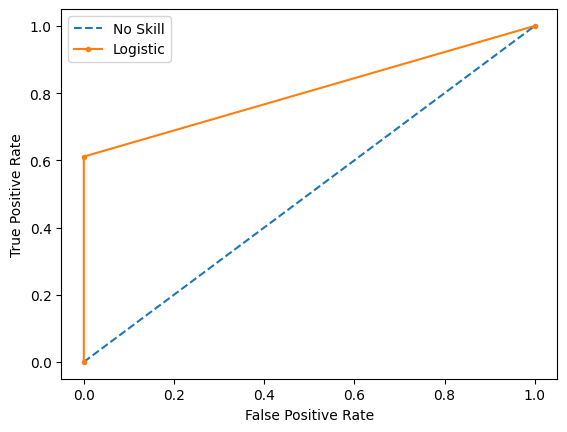

In [1547]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)

pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Além disso, a curva ROC é uma ótima ferramenta para comparar vários algoritmos para analisar qual teve a melhor performance em cada limiar de classificação, porque ainda tem o auxílio do AUC.

AUC é a área sob a curva ROC, representado por um número indicando o quanto o modelo ficou bom para prever a classe positiva e negativa.
Quanto maior o AUC, melhor é o modelo.

Caso o interesse principal não seja o gráfico, mas sim o próprio escore ROC-AUC, podemos reproduzir o valor mostrado no gráfico usando roc_auc_score.

In [1548]:
micro_roc_auc_mi = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average="micro")
micro_roc_auc_ma = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average="macro")
micro_roc_auc_we = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average="weighted")


print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_mi:.2f}")
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_mi:.2f}")
print(f"Weighted-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_mi:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00
Weighted-averaged One-vs-Rest ROC AUC score:
1.00


Agora podemos usar o mesmo modelo no mesmo conjunto de dados e, em vez de prever rótulos de classe diretamente, podemos prever probabilidades.

In [1549]:
# Prever probabilidades
# Podemos usar o predict_proba para recuperar as probabilidades de classe definidas pelo modelo
yhat_proba = model.predict_proba(X_valid)

# Mantenha probabilidades apenas para o resultado positivo
probs = yhat_proba[:, 1]

A seguir, podemos definir um conjunto de limites para avaliar as probabilidades. 

Neste caso, testaremos todos os limites entre 0.0 e 1.0 com tamanho de passo de 0.001, ou seja, testaremos 0.0, 0.001, 0.002, 0.003 e assim por diante até 0.999.

In [1550]:
# Definir limites (thresholds)
thresholds = np.arange(0, 1, 0.001)

A seguir, precisamos de uma maneira de usar um único limite para interpretar as probabilidades previstas.

Isso pode ser conseguido mapeando todos os valores iguais ou maiores que o limite para 1 e todos os valores menores que o limite para 0. 

Definiremos uma função to_labels() para fazer isso, que tomará as probabilidades e o limite como argumento e retornará uma matriz de inteiros em {0, 1}

In [1551]:
# Aplicar limite a probabilidades positivas para criar rótulos
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

Podemos então chamar essa função para cada limite e avaliar os rótulos resultantes usando f1_score().

In [1552]:
# evaluate each threshold
scores = []
for t in thresholds:
    scores.append(balanced_accuracy_score(y_valid, to_labels(probs, t)))

Agora temos uma série de pontuações que avaliam cada limite em nossa matriz de limites.

Tudo o que precisamos fazer agora é localizar o índice do array que possui a maior pontuação (melhor F1-Score) e teremos o limite ideal e sua avaliação.

In [1553]:
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.2f, Balanced Accuracy=%.2f' % (thresholds[ix], scores[ix]))

Threshold=0.05, Balanced Accuracy=1.00


In [1554]:
yhat_proba = model.predict_proba(X_test)

# Mantenha probabilidades apenas para o resultado positivo
probs_test = yhat_proba[:, 1]

print('Balanced Accuracy=%.2f' % balanced_accuracy_score(y_test, to_labels(probs_test, thresholds[ix])))

Balanced Accuracy=0.97


A execução do exemplo relata o limite ideal como 0.26 (em comparação com o padrão de 0,5) que atinge um F1-Score de cerca de 0.95 (em comparação com 0.85).

Nota: Seus resultados podem variar devido à natureza estocástica do algoritmo ou procedimento de avaliação, ou diferenças na precisão numérica. Considere executar o exemplo algumas vezes e compare o resultado médio.

Você pode usar este exemplo como modelo ao ajustar o limite em seu próprio problema, permitindo substituir seu próprio modelo, métrica e até mesmo resolução de limites que deseja avaliar.

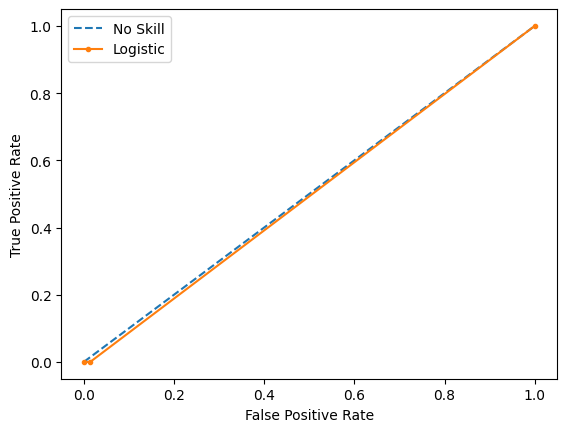

In [1555]:
fpr, tpr, thresholds = roc_curve(y_test, to_labels(probs, thresholds[ix]))

pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

#### **TunedThresholdClassifierCV**

O TunedThresholdClassifierCV é um classificador que ajusta, automaticamente, o limite de decisão usando **validação cruzada**.  O limite ideal é escolhido para maximizar uma determinada métrica.

Este estimador pós-ajusta o limite de decisão (ponto de corte) que é usado para converter estimativas de probabilidade posteriores (ou seja, saída de predict_proba) ou pontuações de decisão (ou seja, saída de decision_function) em um rótulo de classe.

O limite de decisão pode ser ajustado através de diferentes estratégias controladas pelo parâmetro scoring. 

Uma maneira de ajustar o limite é maximizar uma métrica scikit-learn predefinida. Por padrão, a balanced accuracy é a métrica usada, mas esteja ciente de que deve-se escolher uma métrica significativa para seu caso de uso.

Por padrão, TunedThresholdClassifierCV usa uma validação cruzada estratificada de 5 vezes para ajustar o limite de decisão. O parâmetro cv permite controlar a estratégia de validação cruzada. 

É possível ignorar a validação cruzada definindo cv="prefit" e fornecendo um classificador ajustado/treinado. Neste caso, o limite de decisão é ajustado nos dados fornecidos ao método de ajuste. A opção cv="prefit" só deve ser usada quando o classificador fornecido já foi treinado e você deseja apenas encontrar o melhor limite de decisão usando um novo conjunto de validação. Você deve ser extremamente cuidadoso ao usar esta opção. Você nunca deve usar os mesmos dados para treinar o classificador e ajustar o limite de decisão devido ao risco de overfitting. 

Quando a validação cruzada é muito cara, uma alternativa potencial é usar uma única divisão de treinamento e teste/validação, fornecendo um número flutuante no intervalo do parâmetro. Ele divide os dados em um conjunto de treinamento e teste/validação. 

[Tuning the decision threshold for class prediction](https://scikit-learn.org/stable/modules/classification_threshold.html#tunedthresholdclassifiercv)

In [1556]:
#####################################################################################################
# Instanciar o modelo
model = LogisticRegression()

# Treinar o modelo
model.fit(X_train, y_train)

# Prever rótulos
yhat = model.predict(X_test)

# Avaliar o modelo
score = balanced_accuracy_score(y_test, yhat)
print('Balanced Accuracy sem Ajuste do Threshold: %.2f' % score)
#####################################################################################################



#####################################################################################################
# Instanciar o modelo
base_model = LogisticRegression()

# Instancia o Classificador para Definir o Limite de Decisão (Threshold)
model = TunedThresholdClassifierCV(estimator=base_model, scoring='balanced_accuracy') 

# Treina o Modelo e Ajusta o Limite de Decisão
model.fit(X_train, y_train)

# Prever rótulos
yhat = model.predict(X_test)

# Avaliar o modelo
score = balanced_accuracy_score(y_test, yhat)
print('Balanced Accuracy com Ajuste do Threshold: %.2f' % score)
print(f"Threshold {model.best_threshold_:.3f}")

#####################################################################################################

Balanced Accuracy sem Ajuste do Threshold: 0.81
Balanced Accuracy com Ajuste do Threshold: 0.99
Threshold 0.020


In [1557]:
# Instanciar o modelo
base_model = LogisticRegression()

# Instancia o Classificador para Definir o Limite de Decisão (Threshold)
model = TunedThresholdClassifierCV(estimator=base_model, scoring='balanced_accuracy', cv=0.75) 

# Treina o Modelo e Ajusta o Limite de Decisão
model.fit(X_train, y_train)

# Prever rótulos
yhat = model.predict(X_test)

# Avaliar o modelo
score = balanced_accuracy_score(y_test, yhat)
print('Balanced Accuracy com Ajuste do Threshold: %.2f' % score)
print(f"Threshold {model.best_threshold_:.3f}")

Balanced Accuracy com Ajuste do Threshold: 0.97
Threshold 0.030


In [1558]:
# FORMA ERRADA
# Como desabilitamos a validação cruzada, ajustamos o ponto de corte no mesmo conjunto em que o modelo foi treinado, e esse é o motivo do sobreajuste.
# Esta opção deve, portanto, ser utilizada com cautela. 
# É preciso ter certeza de que os dados fornecidos no momento da adaptação ao TunedThresholdClassifierCV não são os mesmos que os dados usados ​​para treinar o classificador subjacente.
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

tuned_model = TunedThresholdClassifierCV(estimator=base_model, scoring='balanced_accuracy', cv="prefit", refit=False)
tuned_model.fit(X_train, y_train)

# Prever rótulos
yhat = tuned_model.predict(X_test)

# Avaliar o modelo
score = balanced_accuracy_score(y_test, yhat)
print('Balanced Accuracy com Ajuste do Threshold: %.2f' % score)
print(f"Threshold {tuned_model.best_threshold_:.3f}")

Balanced Accuracy com Ajuste do Threshold: 0.99
Threshold 0.020


#### **FixedThresholdClassifier**

A classe FixedThresholdClassifier nos permite definir manualmente o limite de decisão. No momento da predição, ele se comporta como o modelo ajustado anterior, mas nenhuma pesquisa é realizada durante o processo de ajuste.

Aqui, reutilizaremos o limite de decisão encontrado na seção anterior para criar um novo modelo e verificar se ele fornece os mesmos resultados.

In [1559]:
# Instanciar o modelo
base_model = LogisticRegression()

# Instancia o Classificador para Definir o Limite de Decisão (Threshold)
model = FixedThresholdClassifier(estimator=base_model, threshold=0.061) 

# Treina o Modelo e Ajusta o Limite de Decisão
model.fit(X_train, y_train)

# Prever rótulos
yhat = model.predict(X_test)

# Avaliar o modelo
score = balanced_accuracy_score(y_test, yhat)
print('Balanced Accuracy com Ajuste do Threshold: %.2f' % score)

Balanced Accuracy com Ajuste do Threshold: 0.97
